# Sidewalk Ratio — Taha Ahmad

## Introduction
I decided to take a look at the ratio between sidewalks and streets since having sidewalks are essential for making an area walkable and WPRDC had a dataset which had data on this metric. This was not my initial approach however, I actually started by analyzing a speed bumps dataset with the idea that speed bumps are one of the most effective mechanisms of preventing vehicular speeding, so a neighborhood with a lot of speed bumps would be safer for pedestrians. However, after doing my analysis (which can be found in taha_speed_bumps.ipynb), I realized that the dataset was too small and was missing too many neighborhoods to be useful to our overall metric.

### The sidewalk ratio dataset has geoids for location information instead of neighborhood names, so I'm using the 2010 Pittsburgh census data set which has both geoid10 and neighborhood information to map between the two. 

In [1]:
import pandas as pd
import geopandas

census = pd.read_csv("2010_Census_Block_Groups.csv").filter(['hood','geoid10'])
census.head()

,hood,geoid10
0,Central Oakland,420030405001
1,North Oakland,420030404001
2,West Oakland,420030402002
3,Crawford-Roberts,420030305002
4,Crawford-Roberts,420030305001


### Create a Dictionary which Maps each Geoid10 to the Neighborhood it is in:

In [2]:
geo_to_hood = {}
for index, row in census.iterrows():
    if row['geoid10'] not in geo_to_hood:
          geo_to_hood[row['geoid10']] = row['hood']

# Demonstration
print(geo_to_hood[420030405001])

Central Oakland


## The Metric
As I stated, I am using a sidewalk to street ratio as my metric. Essentially it is the ratio of the total length of sidewalks and the total length of streets in the neighborhood. The ratio is precalculated in the Sidewalk to Street "Walkability" Ratio dataset. A ratio of 2 means there is a sidewalk on both sides of a street. My understanding is that while many highways, alleys, and trails were removed from the data set, some pedestrian walkways were left in allowing for a ratio higher than 2. 

In [3]:
sr = pd.read_csv("sidewalk_ratio.csv")
sr.head()

,GEOID,NAMELSAD,SidewalkStepLFt,StreetLFt,Ratio
0,420030103001,Block Group 1,13392.83310,30315.86390,0.441776
1,420030103002,Block Group 2,31944.47597,20586.79493,1.551697
2,420030103003,Block Group 3,18655.20798,12122.70024,1.538866
3,420030103004,Block Group 4,14456.19616,11567.62831,1.249711
4,420030201001,Block Group 1,43952.94811,24426.52459,1.799394


### Geoid of the 35th row in sidewalk ratios and the associated neighborhood:

In [4]:
print("Geoid", sr['GEOID'][35], "is in", geo_to_hood[sr['GEOID'][35]])

Geoid 420030605001 is in Polish Hill


### Since a neighborhood can have multiple geoid's inside, create a list of ratios for each neighborhood:

In [5]:
sr_ratios = {} # A dict with the key being the neighborhood name and value: the list of ratios for the neighborhood
for index, row in sr.iterrows():
    try:
        # geo_to_hood[row['GEOID']]) gives us the geoid's neighborhood
        if geo_to_hood[row['GEOID']] in sr_ratios:
            ratio_list = sr_ratios[geo_to_hood[row['GEOID']]]
            ratio_list.append(row['Ratio'])
            sr_ratios[geo_to_hood[row['GEOID']]] = ratio_list
        else:
            ratio_list = []
            ratio_list.append(row['Ratio'])
            sr_ratios[geo_to_hood[row['GEOID']]] = ratio_list
    except:
        continue

# Demonstration
print("Sidewalk ratios in Central Oakland:", sr_ratios["Central Oakland"])

Sidewalk ratios in Central Oakland: [1.602082452, 1.489100874, 1.41298434]


### Get the average sidewalk ratio for each neighborhood:

In [6]:
for key, value in sr_ratios.items():
   avg = 0
   for item in value:
        avg += item
   avg /= len(value)
   sr_ratios[key] = avg
       
print("Central Oakland's sidewalk ratio is " + str(sr_ratios["Central Oakland"]))    

Central Oakland's sidewalk ratio is 1.5013892220000002


### Create a data frame out of the neighborhoods and their ratios and plot them sorted by highest ratio:

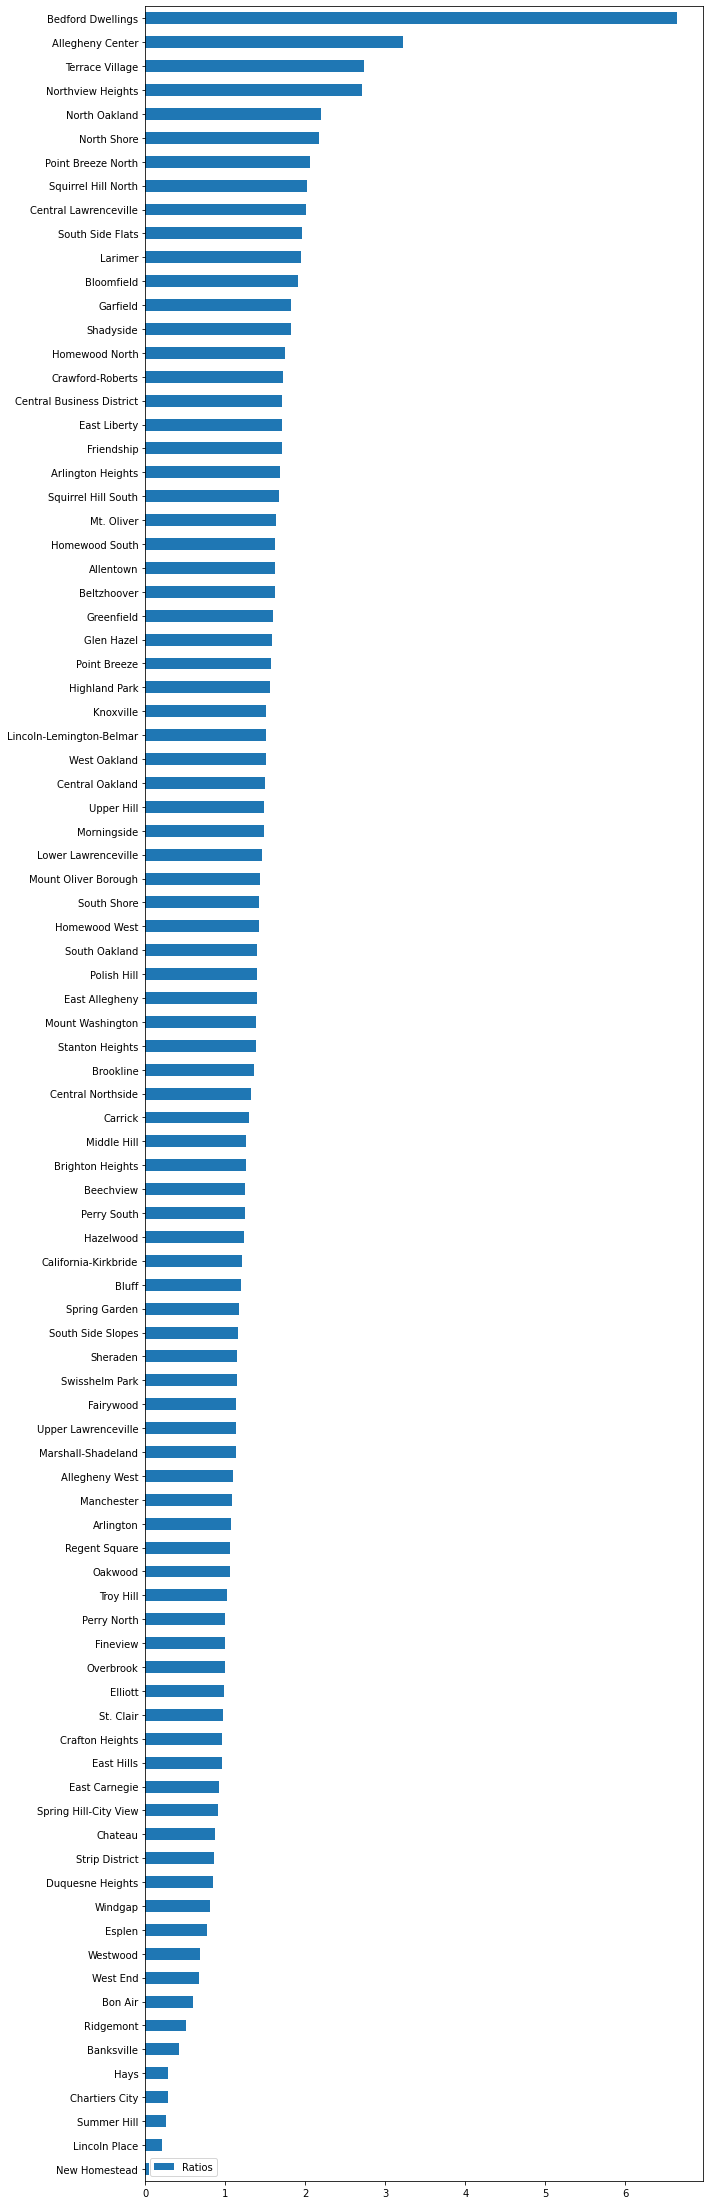

In [7]:
ratios_df = pd.DataFrame.from_dict(sr_ratios, orient="index", columns=['Ratios'])
ratios_df = ratios_df.sort_values(by="Ratios", ascending=True)
ratios_df.plot(kind="barh", figsize=(10, 40))

### That gave a good idea of the best neighborhoods but it wasn't nice to look at.

### Lets try a map instead. Setting up a map of Pittsburgh:

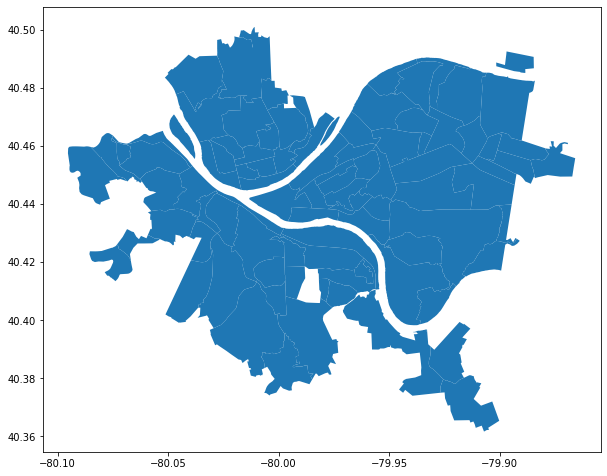

In [8]:
%matplotlib inline
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
neighborhoods.plot(figsize=(10,10)) # plot the geopandas dataframe

### Combine our ratio data frame with the map data frame: 

In [9]:
ratio_map = neighborhoods.merge(ratios_df, right_index=True, left_on='hood')
ratio_map[['hood','Ratios','geometry']].head()

,hood,Ratios,geometry
0,Central Oakland,1.501389,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,2.196612,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,1.506674,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,1.724723,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,0.858929,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."


### Let's plot it: 

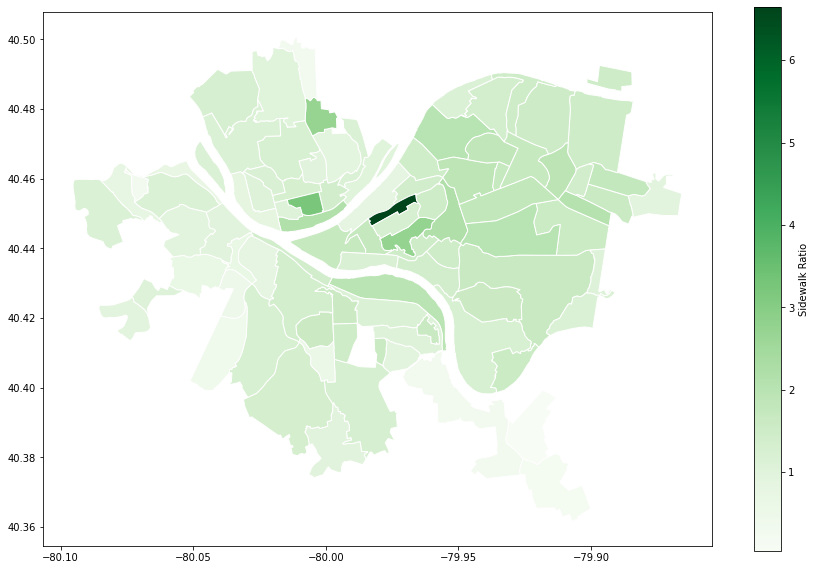

In [10]:
ratio_map.plot(column='Ratios', # set the data to be used for coloring
               cmap='Greens',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Sidewalk Ratio"}, # label the legend
               figsize=(15, 10),         # set the size     
               )

### Let's look at neighborhood's with the worst ratio:

In [11]:
bottom_5 = ratios_df.head()
bottom_5

,Ratios
New Homestead,0.047462
Lincoln Place,0.203395
Summer Hill,0.255189
Chartiers City,0.284980
Hays,0.286175


### Let's plot that:

Text(0, 0.5, 'Sidewalk to street ratio')

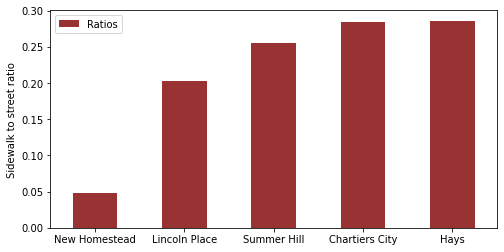

In [12]:
from matplotlib import pyplot
my_color = (0.6,.2,.2)
bottom_5.plot(kind="bar", rot=0, figsize=(8,4), color=my_color)
pyplot.ylabel("Sidewalk to street ratio")

### Now what we are here for, the top 5: 

In [13]:
top_5 = ratios_df.tail()
top_5

,Ratios
North Oakland,2.196612
Northview Heights,2.712593
Terrace Village,2.732608
Allegheny Center,3.227465
Bedford Dwellings,6.644908


Text(0, 0.5, 'Sidewalk to street ratio')

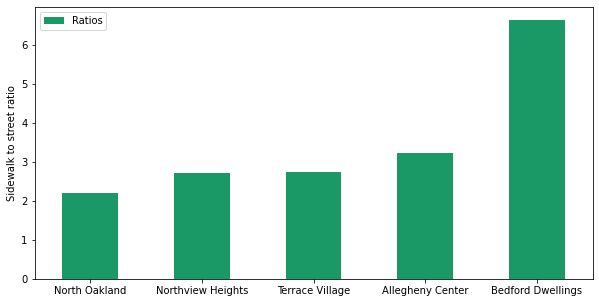

In [14]:
my_color = (0.1,.6,.4)
top_5.plot(kind="bar", rot=0, figsize=(10,5), color=my_color)
pyplot.ylabel("Sidewalk to street ratio")

### Sort by the ratio with the best neighborhoods at the top, and format the dataframe to include a neighborhood column instead of using neighborhoods as an index: 

In [15]:
sorted_ratios = ratios_df.sort_values(by="Ratios", ascending=False)
sorted_ratios = sorted_ratios.reset_index(level=0)
sorted_ratios.rename(columns = {'index':'neighborhood'}, inplace = True)
sorted_ratios.head()

,neighborhood,Ratios
0,Bedford Dwellings,6.644908
1,Allegheny Center,3.227465
2,Terrace Village,2.732608
3,Northview Heights,2.712593
4,North Oakland,2.196612


## The Best Neighborhood
Looking at the results it is clear that Bedford Dwellings has the highest ratio, so by the metric I set, it is the best neighborhood. There are a few reasons that can explain why Bedford Dwellings has such a high ratio. Firstly, as seen in the map below, Bedford Dwellings is situated relatively close to downtown so people are probably encouraged to walk more than drive due to traffic/parking issues. 

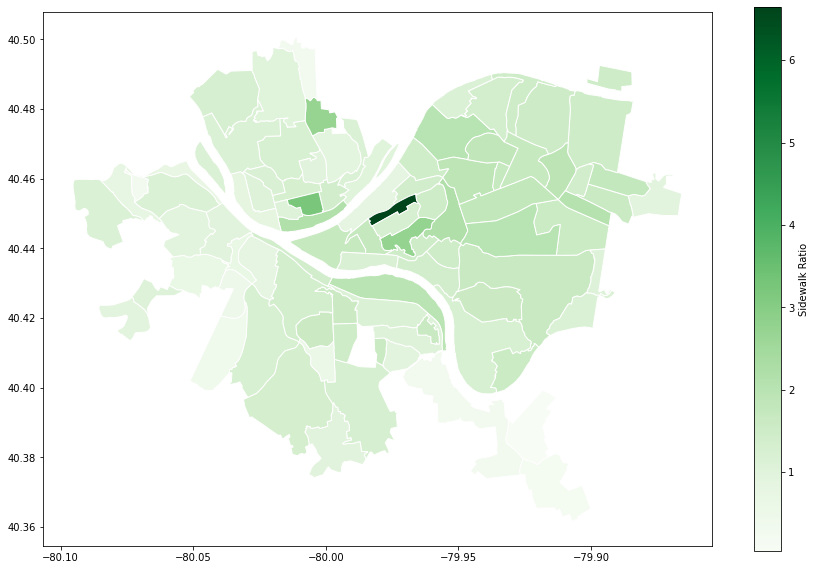

In [16]:
ratio_map.plot(column='Ratios', # set the data to be used for coloring
               cmap='Greens',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Sidewalk Ratio"}, # label the legend
               figsize=(15, 10),         # set the size     
               )

More importantly however, a quick google search reveals that Bedford Dwellings has a lot of public housing constructed by the Housing Authority of Pittsburgh. As seen in the images of Bedford Dwellings below, this sort of housing usually has internal sidewalks between buildings that are not attached to any streets and that is probably driving up the sidewalk to street ratio. 

![Bedford Dwellings](https://cmg-cmg-tv-10080-prod.cdn.arcpublishing.com/resizer/khCNYpJUzDe1Uw5pIN8naCgm9SA=/1440x0/filters:format(jpg):quality(70)/cloudfront-us-east-1.images.arcpublishing.com/cmg/UC22KNDNERBCLC3HUBPRLC65LE.jpg)

![Bedford Dwellings Sidewalk](https://hacp.org/app/uploads/2018/10/bedford-dwellings-36VC4087.jpg)

## Conclusion
I don't know many Pittsburgh neighborhoods well, so I guess my favorite is the one I currently live in: Shadyside. I have found it pretty walkable with sidewalks on nearly every street, but it came in 14th place with a ratio of ~1.82. 

In [17]:
sorted_ratios.loc[sorted_ratios['neighborhood'] == "Shadyside"]

,neighborhood,Ratios
13,Shadyside,1.821344


### Store the results found in this notebook to use in our final combined notebook

In [18]:
%store sorted_ratios

Stored 'sorted_ratios' (DataFrame)
